## LSTMs in PyTorch
In this section, we'll investigate how to implement an LSTM in PyTorch that uses image embeddings from ResNet.

In [ ]:
import torch
import torch.nn as nn
import torchvision as tv
from torchvision.datasets import MovingMNIST
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Inspecting the Data


In [ ]:
train_dataset = MovingMNIST(root=".", split="train", download=True)

100%|██████████| 819200096/819200096 [00:13<00:00, 60090587.05it/s]


The dataset has 10000 items
Each data point has shape torch.Size([10, 1, 64, 64])


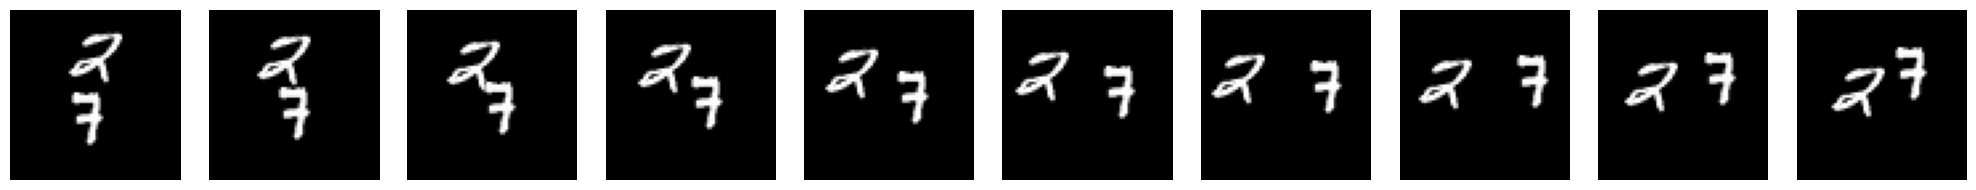

In [ ]:
print(f"The dataset has {len(train_dataset)} items")

for item in train_dataset:
  print("Each data point has shape", item.shape)
  fig, axes = plt.subplots(1, 10, figsize=(20, 2))
  for i in range(item.shape[0]):
      img = item[i, 0, :, :]
      axes[i].imshow(img, cmap='gray')
      axes[i].axis('off')

  plt.tight_layout()
  plt.show()
  break

In [ ]:
dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

for batch_data in dataloader:
  # batch_data will have shape (B,S,C,H,W)
  input = torch.repeat_interleave(batch_data[:,:9], repeats=3, dim=2).permute(1,0,2,3,4)
  target = batch_data[:,1:].permute(1,0,2,3,4)
  print("Input Shape:", input.shape)
  print("Output Shape:", target.shape)
  break

Input Shape: torch.Size([9, 8, 3, 64, 64])
Output Shape: torch.Size([9, 8, 1, 64, 64])


In other words, we are feeding the model 8 sequences, each containing 9 64x64 images.

Next, we will use a pre-trained CNN and use it to create embeddings for our image

# Building an Encoder and Decoder

In [ ]:
# Encoding Backbone
resnet_net = torchvision.models.resnet18(weights="DEFAULT")
modules = list(resnet_net.children())[:-1]
backbone = torch.nn.Sequential(*modules)

test_inp = torch.rand(8,3,64,64)
backbone(test_inp).shape

torch.Size([8, 512, 1, 1])

In [ ]:
# Decoder Module

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.layer5 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x

decoder = Decoder()
input_tensor = torch.randn(8, 512, 1, 1)
output_tensor = decoder(input_tensor)
print(output_tensor.shape)  # Should output torch.Size([1, 1, 64, 64])

torch.Size([8, 1, 64, 64])


# Building an LSTM Model

In [ ]:
model = torch.nn.LSTM(input_size=512, hidden_size=512) # Expects input of shape (Seq Length, Batch Size, Embedding Dim)

In [ ]:
test_lstm_inp = torch.rand(9,8,512)
out, (hidden_state, cell_state) = model(test_lstm_inp)
print("LSTM Output Shape:", out.shape)

LSTM Output Shape: torch.Size([9, 8, 512])


# Putting Everything Together

In [ ]:
for batch_data in dataloader:
  batch_size = batch_data.shape[0]
  # Make Input RGB, and of shape (L,B,C,H,W)
  input = torch.repeat_interleave(batch_data[:,:9], repeats=3, dim=2).permute(1,0,2,3,4)
  # No need to make Output RGB
  target = batch_data[:,1:].permute(1,0,2,3,4)

  # Don't pass gradients to the ResNet, we don't want to change those weights
  with torch.no_grad():
    L, B, C, H, W = input.shape
    backbone_inp = input.reshape(-1,C,H,W).float()
    embedded_input = backbone(backbone_inp).reshape(L, B, -1)

  model_preds, (h, c) = model(embedded_input)

  decoder_inp = model_preds.reshape(L*B, -1, 1, 1)
  decoded_image = decoder(decoder_inp).reshape(L, B, 1, 64, 64)
  print("Preds shape", decoded_image.shape)
  print("GT Shape", target.shape)

Preds shape torch.Size([9, 8, 1, 64, 64])
GT Shape torch.Size([9, 8, 1, 64, 64])


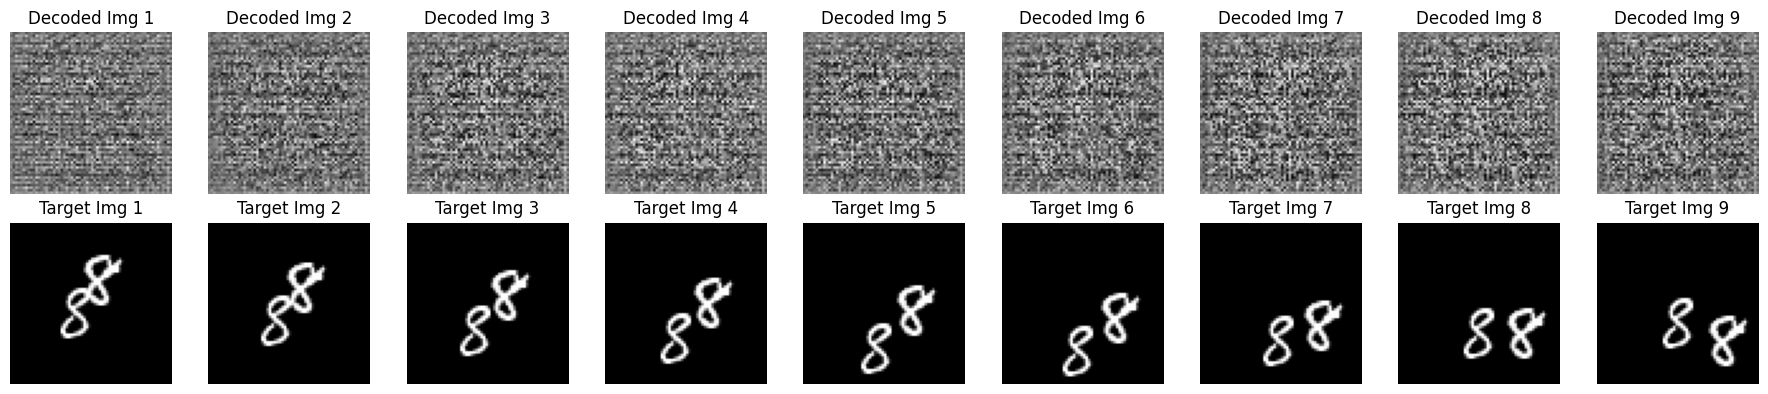

In [ ]:
# Visualize outputs
# Select the 0th element along dim=1 for both tensors
decoded_img_0 = decoded_image[:, 0, :, :].detach().numpy()
target_0 = target[:, 0, :, :].detach().numpy()

# Visualize the two sequences of images in a grid
fig, axes = plt.subplots(nrows=2, ncols=9, figsize=(18, 4))

for i in range(9):
    # Display decoded_img_0 images in the first row
    axes[0, i].imshow(decoded_img_0[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Decoded Img {i+1}')

    # Display target_0 images in the second row
    axes[1, i].imshow(target_0[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Target Img {i+1}')

plt.tight_layout()
plt.show()

Now use your favorite loss function and optimizer! Anything like the L2 loss works well too

# Creating a Transformer in PyTorch

In [ ]:
vit = torchvision.models.vit_b_32(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth
100%|██████████| 337M/337M [00:03<00:00, 99.7MB/s]


In [ ]:
random_inp = torch.rand(16, 3, 224, 224)
out = vit(random_inp)
out.shape

torch.Size([16, 1000])

## Input sizes and Vision Transformer
In a Vision Transformer, an image is divided into fixed-size non-overlapping patches, and each patch is linearly embedded into a flat vector. These vectors are then processed by the transformer layers. Since the transformer layers expect a fixed sequence length, the number of patches in the image must remain constant. If the input image size changes, the number of patches will also change, leading to a mismatch in the transformer's input sequence length.

In contrast, Convolutional Neural Networks (CNNs) use convolutional layers that apply filters with a sliding window mechanism. These layers can process images of varying sizes because the sliding window operation is inherently local and translation-invariant. As long as the spatial dimensions (height and width) are large enough to accommodate the filter size, the convolution can be applied. However, the output size will change depending on the input size, and any fully connected layers later in the network must be adapted accordingly.

Let's investigate the output dimensionality

In [ ]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

## You can now use a suitable decoder to develop models for classification, regression, segmentation, and so on.

In [ ]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4147 sha256=77ebdd4c045f254e0f12feeb7e9f16b5b094ccaffed29393a38466d06ad5c156
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
from torchviz import make_dot
from IPython.display import Image, display

dot = make_dot(out, params=dict(list(vit.named_parameters())))
# Save the dot file as a PNG
dot.format = 'png'
dot.render('rnn_torchviz')

# Display the saved PNG in the notebook
display(Image('rnn_torchviz.png'))